In [1]:
import pandas as pd
import ipywidgets as w
from IPython.display import display, IFrame
import pyspark
from pyspark.sql import SQLContext, functions, types
from pyspark.sql import Row
import matplotlib.pyplot as plt
from hotel_rec import *
import json
import constants as const
%matplotlib inline

In [2]:
sc=pyspark.SparkContext(appName=const.HOTEL_REC_APP_NAME)
spark = SQLContext(sc)

C:\Users\thapq\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## User details and Preferences

In [3]:
name = w.Text(description="Tên người dùng")
place = w.Text(description="Tỉnh/Thành phố")
v1 = w.VBox([name,place])

start = w.DatePicker(description='Ngày bắt đầu', disabled=False)
end = w.DatePicker(description='Ngày kết thúc', disabled=False)
v2 = w.VBox([start,end])

out = w.HBox([v1,v2])
display(out)

In [5]:
hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
hotel_amenity_df = spark.read.json(const.DIR_DATA_HOTEL_AMENITIES)

hotel_df.createOrReplaceTempView('hotel_df')
hotel_amenity_df.createOrReplaceTempView('hotel_amenity_df')

In [6]:
# Tìm ra top 15 độ tiện nghi của khách sạn
temp_amenity_df  = spark.sql("SELECT amenities, COUNT(amenities) AS tot_count FROM hotel_amenity_df GROUP BY amenities ORDER BY tot_count DESC")
top_amenities = [x[0] for x in temp_amenity_df.head(16) if x[0] != '']

# Lựa chọn độ tiện nghi của du khách (chọn 5)
amenities_pref = []
def on_button_clicked(b):
    if b.description in amenities_pref:
        return
    
    print(b.description)
    amenities_pref.append(b.description)
    if(len(amenities_pref) < 5):
        print("Select {x} more!\n".format(x=5-len(amenities_pref)))
        
but_layout = w.Layout(width='100%', height='100px')
but_items = [w.Button(description=c, layout=but_layout) for c in top_amenities]
on_clk = [item.on_click(on_button_clicked) for item in but_items]
r1 = w.VBox([i for i in but_items[:5]])
r2 = w.VBox([i for i in but_items[5:10]])
r3 = w.VBox([i for i in but_items[10:]])
buttons = w.HBox([r1,r2,r3])

print("Select atleast 5 amenities:")
display(buttons)

Select atleast 5 amenities:


 Nonsmoking hotel
Select 4 more!

 Nonsmoking rooms
Select 3 more!

 Free High Speed Internet WiFi
Select 2 more!

 Air conditioning
Select 1 more!

Free parking


## Model training and evaluation

best rank :  12
best RMSE:0.0002040336554347435


<BarContainer object of 3 artists>

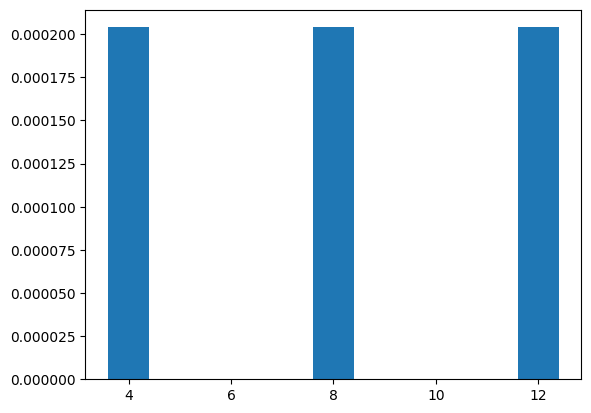

In [7]:
# write list to JSON file
temp_json_amenities = []
for amenity in amenities_pref:
    temp_json_amenities.append({'amenities_pref': amenity})

with open('temp_amenities_pref.json', 'w') as f:
    json.dump(temp_json_amenities, f)

amenities_pref_df = spark.read.json('temp_amenities_pref.json')

usr_rating = amenities_rating(spark, amenities_pref_df, hotel_amenity_df)
rank, error, errors, usrid_s2, model = model_train(spark, usr_rating)

print("best rank : ",rank)
print("best RMSE:" +str(error))
plt.bar([4,8,12], height=errors)

## Getting Recommendation

In [8]:
# check if model is None
model

ALSModel: uid=ALS_0ba24b3a617b, rank=12

In [9]:
u_tempdf = get_hotel_recc(spark, usrid_s2, model)
hotel_df = hotel_df.join(u_tempdf, "id").withColumn("address",functions.lower(functions.col("address")))
user_location = place.value.lower()
hotel_sugg = hotel_df.where(hotel_df.address.contains(user_location))
recc = hotel_sugg.dropna().toPandas()

In [10]:
%%capture
final = dict()
final['address'] = recc[:5]['address'].values.tolist()
final['amenities'] = recc[:5]['amenities'].values.T.tolist()
final['experience'] = recc[:5]['hotel_experience'].values.tolist()
final['name'] = recc[:5]['hotel_name'].values.tolist()
final['rating'] = recc[:5]['hotel_rating'].values.tolist()
final['location'] = [i[1:-1] for i in recc[:5]['location'].values.tolist()]
final['price'] = recc[:5]['price'].values.tolist()
final['image'] = [get_image(i) for i in recc[:5]['hotel_name'].values.tolist()]



## Final Output

In [11]:
days = (end.value - start.value).days
tab_recc = get_hotel_output(days, final)
display(tab_recc)